# CNN

In [1]:
import tensorflow as tf
from tensorflow import keras
import stella
import glob
import numpy as np
import sys
import os

sys.path.insert(1, '../scripts')
sys.path.insert(1, '../stella')
from utils import *
import lightkurve as lk
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
%load_ext tensorboard
print(tf.config.list_physical_devices())

2024-10-11 10:12:14.644339: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


/home/astro/phrdhx/micromamba/envs/nets2/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /home/astro/phrdhx/.lightkurve/cache. Please move all the files in the legacy directory /home/astro/phrdhx/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')
plt.rc('text',usetex=False)
plt.rcParams['axes.labelsize'] = 14

In [3]:
cadences = 168
frac_balance = 0.6

In [4]:
exoplanets = stella.FlareDataSet(fn_dir='../models/exoplanets5k-scaled-to-baseline/',
                         catalog='../catalogs/exoplanets5k-scaled-to-baseline.txt',cadences=cadences,frac_balance=1,training=1,validation=0)

Reading in training set files.


100%|█████████████████████████████████| 4999/4999 [00:02<00:00, 2388.16it/s]


Number of positive class training data: 4999
Number of negative class training data: 0
Number of positive class validation data: 0
Number of negative class validation data: 1
Size of augmented data (training set only): 0
Class label (training): 1, Count: 4999
Class label (validation): None, Count: 1
Total size of training set: 4999
No second class to calculate imbalance.


In [5]:
fbinaries = stella.FlareDataSet(fn_dir='../models/binaries5k-scaled-to-baseline/',
                         catalog='../catalogs/binaries5k-scaled-to-baseline.txt',frac_balance=1,cadences=cadences,training=1,validation=0)

Reading in training set files.


100%|█████████████████████████████████| 4999/4999 [00:02<00:00, 2379.91it/s]


Number of positive class training data: 4999
Number of negative class training data: 0
Number of positive class validation data: 0
Number of negative class validation data: 1
Size of augmented data (training set only): 0
Class label (training): 1, Count: 4999
Class label (validation): None, Count: 1
Total size of training set: 4999
No second class to calculate imbalance.


In [6]:
rbinaries = stella.FlareDataSet(fn_dir='../models/binaries-s18-scaled-to-baseline/',
                         catalog='../catalogs/binaries-s18-scaled-to-baseline.txt',cadences=cadences,frac_balance=1,training=1,validation=0)

Reading in training set files.


100%|███████████████████████████████████| 341/341 [00:00<00:00, 1277.35it/s]

Number of positive class training data: 5104
Number of negative class training data: 0
Number of positive class validation data: 0
Number of negative class validation data: 1
Size of augmented data (training set only): 0
Class label (training): 1, Count: 5104
Class label (validation): None, Count: 1
Total size of training set: 5104
No second class to calculate imbalance.


In [7]:
sines = stella.FlareDataSet(fn_dir='../models/sines-scaled-to-baseline-v2/',
                         catalog='../catalogs/sines-scaled-to-baseline-v2.txt',cadences=cadences,frac_balance=1,training=1,validation=0)

Reading in training set files.


100%|█████████████████████████████████| 5000/5000 [00:02<00:00, 2382.88it/s]


Number of positive class training data: 8260
Number of negative class training data: 0
Number of positive class validation data: 0
Number of negative class validation data: 1
Size of augmented data (training set only): 0
Class label (training): 1, Count: 8260
Class label (validation): None, Count: 1
Total size of training set: 8260
No second class to calculate imbalance.


In [8]:
ds = stella.FlareDataSet(fn_dir='../models/comets50k-scaled-to-baseline/',
                         catalog='../catalogs/comets50k-scaled-to-baseline.txt',cadences=cadences,frac_balance=0.79,
                         merge_datasets=True,other_datasets=[exoplanets,fbinaries,rbinaries,sines],other_datasets_labels=[2,3,4,5])

Reading in training set files.


100%|███████████████████████████████| 49998/49998 [00:20<00:00, 2390.87it/s]


Number of positive class training data: 39998
Number of negative class training data: 40510
Number of positive class validation data: 5000
Number of negative class validation data: 5064
Size of augmented data (training set only): 0
Class label (training): 0, Count: 40510
Class label (training): 1, Count: 39998
Class label (validation): 0, Count: 2727
Class label (validation): 1, Count: 5000
Class label (validation): 2, Count: 500
Class label (validation): 3, Count: 500
Class label (validation): 4, Count: 511
Class label (validation): 5, Count: 826
Total size of training set: 80508
Total size of validation set: 10064
Total size of test set: 10064
Approximate class imbalance: 1.0


In [9]:
#ds.save(output='../ds.pkl')

In [10]:
# ds = stella.FlareDataSet(fn_dir='../models/comets50k-scaled-to-baseline/',
#                          catalog='../catalogs/comets50k-scaled-to-baseline.txt',cadences=cadences,frac_balance=0.68,augment_portion=0.2)

## Training Data Plots

39998 positive class in training set
40510 true negative class in training set


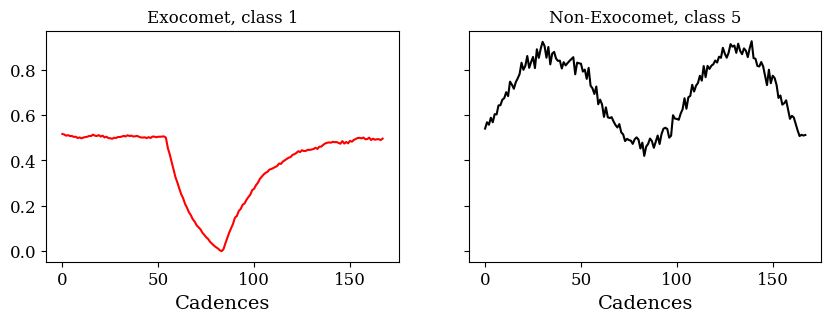

In [11]:
m = -1
ind_pc = np.where(ds.train_labels_ori==1)[0] 
ind_nc = np.where(ds.train_labels_ori!=1)[0] 
print(len(ind_pc),"positive class in training set")
print(len(ind_nc),"true negative class in training set")

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3),
                               sharex=True, sharey=True)
ax1.plot(ds.train_data[ind_pc[m]], 'r')
ax1.set_title(f'Exocomet, class {ds.train_labels_ori[ind_pc[m]]}')
ax1.set_xlabel('Cadences')
ax2.plot(ds.train_data[ind_nc[m]], 'k')
ax2.set_title(f'Non-Exocomet, class {ds.train_labels_ori[ind_nc[m]]}')
ax2.set_xlabel('Cadences');

In [12]:
# fig, ax = plt.subplots(2,2, figsize=(6,6),sharex=True, sharey=True)
# ax[0,0].plot(ds.train_data[ind_pc[97]])
# ax[0,1].plot(ds.train_data[ind_pc[2]])
# ax[1,1].plot(ds.train_data[ind_pc[438]])
# ax[1,0].plot(ds.train_data[ind_pc[11267]]) # -22223
# plt.suptitle('Exocomet',y=0.97,x=0.55)
# fig.supxlabel('Cadences',y=0.03,x=0.55)
# fig.supylabel('Min-Max Scaled Flux')
# plt.gcf().patch.set_alpha(0.5)
# plt.tight_layout()
# plt.savefig('negative.png',dpi=300)

## Training Data Imbalance

In [13]:
print(f"{np.round(100 * len(ind_pc) / len(ind_nc))}% class imbalance")
print(len(ind_pc), "positive class")
print(len(ind_nc), "negative class")

99.0% class imbalance
39998 positive class
40510 negative class


## Validation data plots

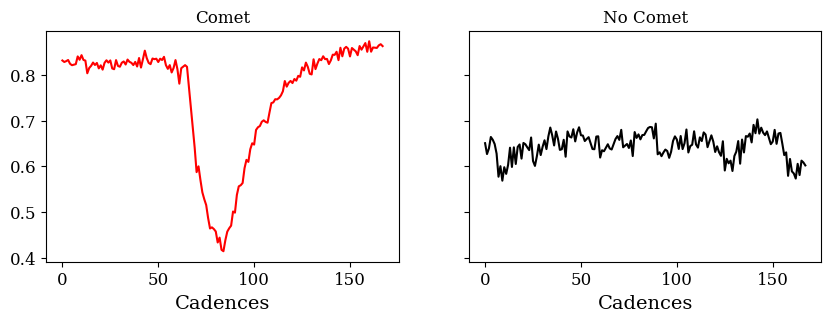

In [14]:
val_pc = np.where(ds.val_labels==1)[0] 
val_nc = np.where(ds.val_labels!=1)[0] 


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3),
                               sharex=True, sharey=True)
ax1.plot(ds.val_data[val_pc[1]], 'r')
ax1.set_title('Comet')
ax1.set_xlabel('Cadences')
ax2.plot(ds.val_data[val_nc[-22]], 'k')
ax2.set_title('No Comet')
ax2.set_xlabel('Cadences');

In [15]:
print(f"{np.round(100 * len(val_pc) / len(val_nc))}% class imbalance")
print(len(val_pc), "positive class")
print(len(val_nc), "negative class")

99.0% class imbalance
5000 positive class
5064 negative class


In [16]:
# p = np.where(sines.train_labels == 1)[0]
# dsmodels = sines.train_data[p]

# num_sets = dsmodels.shape[0] // 100

# for set_index in range(num_sets):
#     start_index = set_index * 100
#     end_index = min((set_index + 1) * 100, dsmodels.shape[0])  # Ensure not to exceed the length of the data

#     # Create a new 10x10 grid of subplots for each set
#     fig, axs = plt.subplots(10, 10, figsize=(20, 20))

#     # Flatten the axes array for easier iteration
#     axs = axs.flatten()

#     # Iterate over the elements in the current set and plot each in the grid
#     for i in range(start_index, end_index):
#         plot_index = i % 100  # Calculate the index within the current grid
#         axs[plot_index].scatter(range(0,len(dsmodels[i,:,0])),dsmodels[i, :, 0],s=4)  
#         axs[plot_index].set_title(f"Plot {i}")  # Title for each subplot
#         axs[plot_index].axvline(84,linestyle='--',color='red')
#     # Hide any remaining empty subplots
#     for j in range(end_index - start_index, len(axs)):
#         axs[j].axis('off')

    
#     plt.tight_layout()  # Adjust layout
#     #plt.savefig(f'example-models{start_index}-{end_index}.png',dpi=200,bbox_inches='tight')
#     plt.show()  # Show the grid of plots
#     break

### If we followed `stella`

In [17]:
filter1 = 16
filter2 = 64
kernel_size1 = 7
kernel_size2 = 3
pool_size = 2
dropout = 0.1
dense = 64
l2val = 0.001
input_shape = (cadences, 1)
activation = 'relu'

# Define the model layers as a list
layers = [
    tf.keras.layers.Conv1D(
        filters=filter1,
        kernel_size=kernel_size1,
        activation=activation,
        padding="same",
        input_shape=input_shape,
        kernel_regularizer=tf.keras.regularizers.l2(l2val)  # Optional: include if needed
    ),
    tf.keras.layers.MaxPooling1D(pool_size=pool_size),
    tf.keras.layers.Dropout(dropout),
    
    tf.keras.layers.Conv1D(
        filters=filter2,
        kernel_size=kernel_size2,
        activation=activation,
        padding="same",
        kernel_regularizer=tf.keras.regularizers.l2(l2val)  # Optional: include if needed
    ),
    tf.keras.layers.MaxPooling1D(pool_size=pool_size),
    tf.keras.layers.Dropout(dropout),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(
        dense,
        activation=activation,
        kernel_regularizer=tf.keras.regularizers.l2(l2val)  # Optional: include if needed
    ),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(1, activation="sigmoid")
]

In [18]:
cnn = stella.ConvNN(output_dir='../cnn-models/',ds=ds) #,layers=layers)
SEED = [44]
epochs = 10
bs = 512

In [19]:
#%tensorboard --logdir './logs'
cnn.train_models(seeds=SEED, epochs=epochs,batch_size=bs,shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 168, 16)           128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 84, 16)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 84, 16)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 84, 64)            3136      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 42, 64)            0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 42, 64)            0

/home/astro/phrdhx/micromamba/envs/nets2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


315/315 [==============================] - 1s 4ms/step
Shape of y_true: (10064,)
Unique values in y_true: [0 1 2 3 4 5]
Shape of y_binary: (10064,)
Unique values in y_binary: [0 1]
Number of class_names: 6
class_names: ['0', '1', '2', '3', '4', '5']
315/315 [==============================] - 1s 4ms/step
Unique classes in y_true: [0 1 2 3 4 5]
315/315 [==============================] - 1s 4ms/step


/home/astro/phrdhx/micromamba/envs/nets2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/astro/phrdhx/micromamba/envs/nets2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/astro/phrdhx/micromamba/envs/nets2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

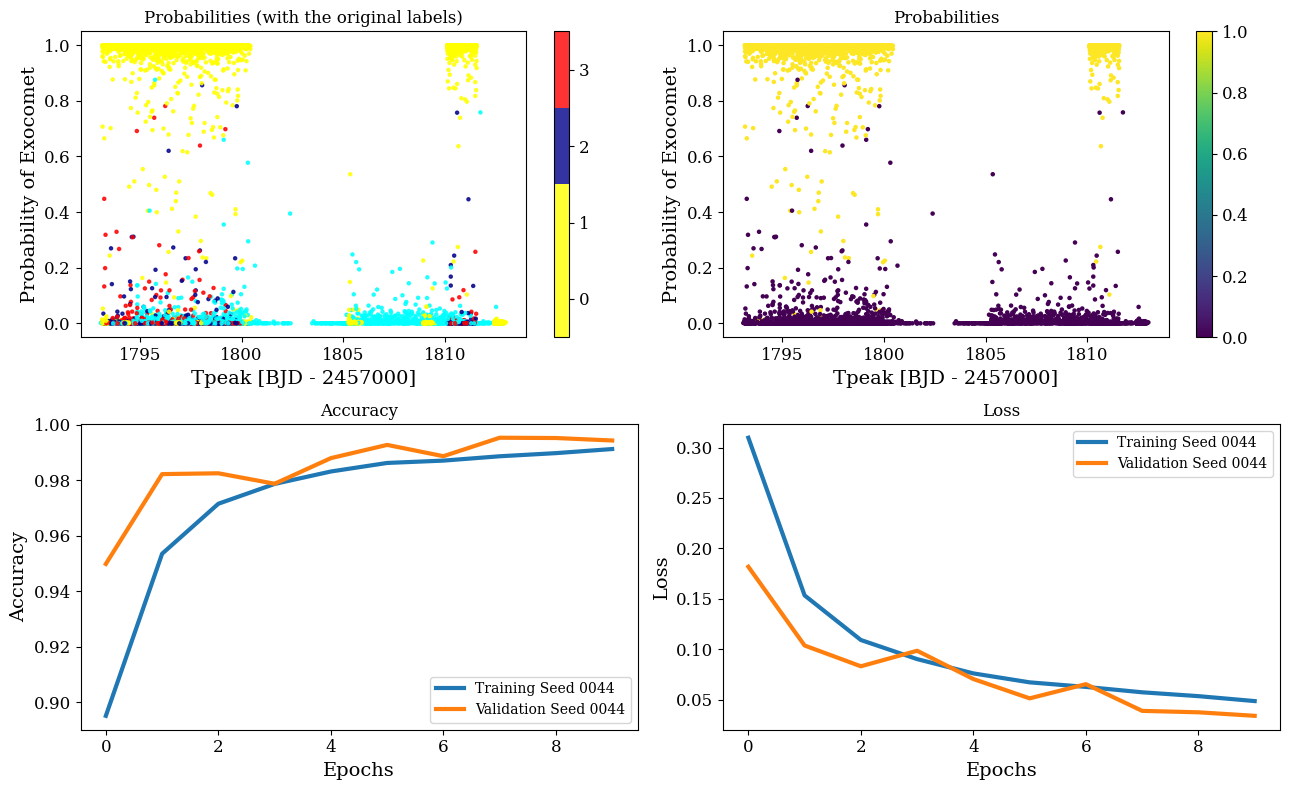

In [20]:
from matplotlib import cm
import matplotlib.colors as mcolors
import numpy as np

if type(SEED) == list:
    for seeds in SEED:
        # Create a custom colormap
        custom_cmap = mcolors.ListedColormap(['yellow', 'darkblue', 'red','cyan'])

        fig, axes = plt.subplots(2, 2, figsize=(13,8))
        formatted_seed = f'{seeds:04}'

        # Plot ground truth
        sc = axes[0, 0].scatter(cnn.val_pred_table['tpeak'], cnn.val_pred_table[f'pred_s{formatted_seed}'],
                                c=cnn.val_pred_table['labels'], cmap=custom_cmap, label=f'Seed {formatted_seed}',s=5,alpha=0.8)
        axes[0, 0].set_xlabel('Tpeak [BJD - 2457000]')
        axes[0, 0].set_ylabel('Probability of Exocomet')
        axes[0,0].set_title('Probabilities (with the original labels)')
        plt.colorbar(sc, ax=axes[0, 0], ticks=np.arange(4), boundaries=np.arange(4+1)-0.5)

        # Plot loss
        axes[1, 1].plot(cnn.history_table[f'loss_s{formatted_seed}'], label=f'Training Seed {formatted_seed}', lw=3)
        axes[1, 1].plot(cnn.history_table[f'val_loss_s{formatted_seed}'], label=f'Validation Seed {formatted_seed}', lw=3)
        axes[1, 1].set_xlabel('Epochs')
        axes[1, 1].set_ylabel('Loss')
        axes[1,1].set_title('Loss')
        axes[1, 1].legend()

        # Plot accuracy
        axes[1, 0].plot(cnn.history_table[f'accuracy_s{formatted_seed}'], label=f'Training Seed {formatted_seed}', lw=3)
        axes[1, 0].plot(cnn.history_table[f'val_accuracy_s{formatted_seed}'], label=f'Validation Seed {formatted_seed}', lw=3)
        axes[1, 0].set_xlabel('Epochs')
        axes[1, 0].set_ylabel('Accuracy')
        axes[1, 0].set_title('Accuracy')
        axes[1, 0].legend()

        # Plot ground truth (gt)
        sc2 = axes[0, 1].scatter(cnn.val_pred_table['tpeak'], cnn.val_pred_table[f'pred_s{formatted_seed}'],
                                 c=cnn.val_pred_table['gt'], label=f'Seed {formatted_seed}',s=5)
        axes[0, 1].set_xlabel('Tpeak [BJD - 2457000]')
        axes[0, 1].set_ylabel('Probability of Exocomet')
        axes[0,1].set_title('Probabilities')
        plt.colorbar(sc2, ax=axes[0, 1])#, ticks=np.arange(2)#, boundaries=np.arange(2)-0.5)
    
        plt.tight_layout()
        plt.savefig(f'../plots/metrics-{SEED}.png',dpi=300,bbox_inches='tight')
        plt.show()

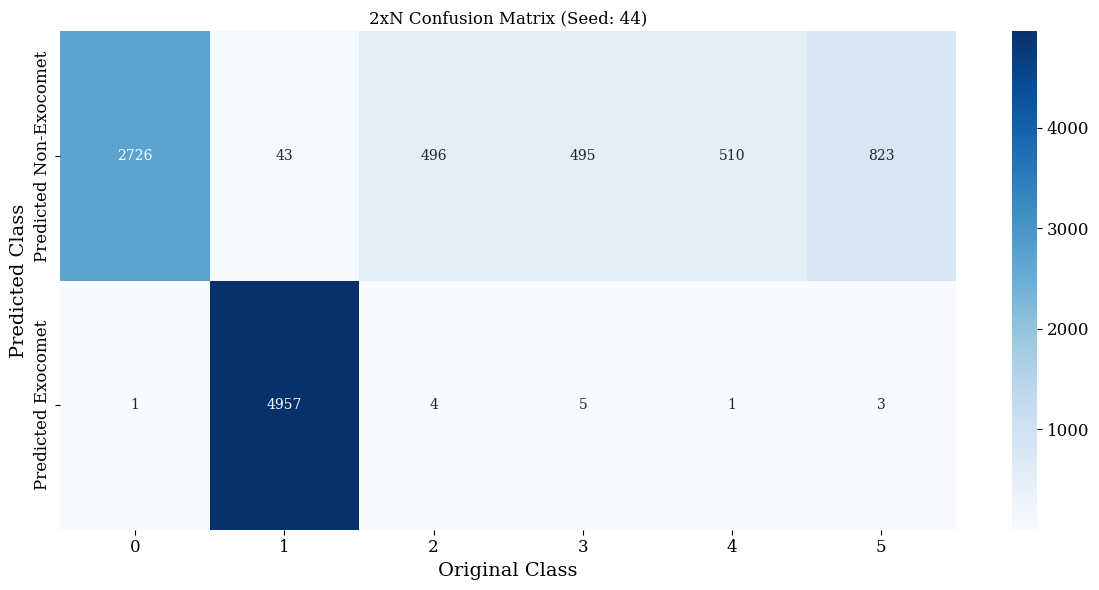

In [26]:
cnn.confusion_matrix_2xN_plot

Colour plot with SNR value

### Confusion matrix

In [ ]:
cnn.confusion_matrix2_report

In [ ]:
cnn.confusion_matrix2_plot

---

## Predicting

In [99]:
# files2 = glob.glob('../data/272-candidates/*')
# np.random.shuffle(files2)

# fo = '../models/272-candidates-npy/'
# os.makedirs(fo,exist_ok=True)
# for i in files2:
#     try:
#         lc, info = import_lightcurve(i)
#         t = lc['TIME']
#         f = lc['PCA_FLUX']
#         fe = lc['FLUX_ERR']
#         np.save(f"{fo}/{info['TIC_ID']}.npy", np.array([t,f,fe]))
#     except:
#         print(f"could not import TIC {info['TIC_ID']}")
         

In [26]:
files3 = glob.glob('../models/272-candidates-npy/*')
np.random.shuffle(files3)
files3[0:3]

['../models/272-candidates-npy/94335925.npy',
 '../models/272-candidates-npy/294343592.npy',
 '../models/272-candidates-npy/323427650.npy']

In [20]:
modelname = f'../cnn-models/ensemble_s0044_i0150_b0.8.h5'

In [24]:
lk.search_lightcurve('TIC 419365265',mission='TESS')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 07,2019,QLP,1800,419365265,0.0
1,TESS Sector 34,2021,QLP,600,419365265,0.0
2,TESS Sector 35,2021,QLP,600,419365265,0.0
3,TESS Sector 61,2023,QLP,200,419365265,0.0
4,TESS Sector 07,2019,GSFC-ELEANOR-LITE,1800,419365265,0.0
5,TESS Sector 08,2019,GSFC-ELEANOR-LITE,1800,419365265,0.0
6,TESS Sector 07,2019,TGLC,1800,419365265,0.0


In [21]:
lc = lk.search_lightcurve('TIC 229790952',mission='TESS',sector=[15],author='GSFC-ELEANOR-LITE').download()
lc = lc[lc.quality.value == 0]

f = np.array((lc.flux.value/np.nanmedian(lc.flux.value)) - 1)
f = np.array(f / np.nanstd((lc.flux.value/np.nanmedian(lc.flux.value))-1))
f = f + 1
f = f[~np.isnan(f)]
f = (f - np.min(f)) / (np.max(f) - np.min(f))

cnn.predict(modelname=modelname,
            times=lc.time.value,
            fluxes=f,
            errs=lc.flux_err.value)

plt.figure(figsize=(10,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=cnn.predictions[0], vmin=0, vmax=1,s=10)
plt.colorbar(label='Probability of Exocomet')
#plt.axvline(cnn.predict_time[0][np.argmax(cnn.predictions)],color='red',linestyle='--',zorder=1)
plt.xlabel('Time [BTJD]')
plt.title('TIC 419365265')
plt.tight_layout()
plt.ylabel('Min-Max Scaled Flux')
plt.gcf().patch.set_alpha(0.5)
plt.ylim([-0.5,3.5])
plt.savefig('tic280832588.png',dpi=300,bbox_inches='tight')

No data found for target "TIC 229790952".
/Users/azib/micromamba/envs/nets2/lib/python3.8/site-packages/lightkurve/search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'quality'

100%|█| 1/1 [00:00<00:


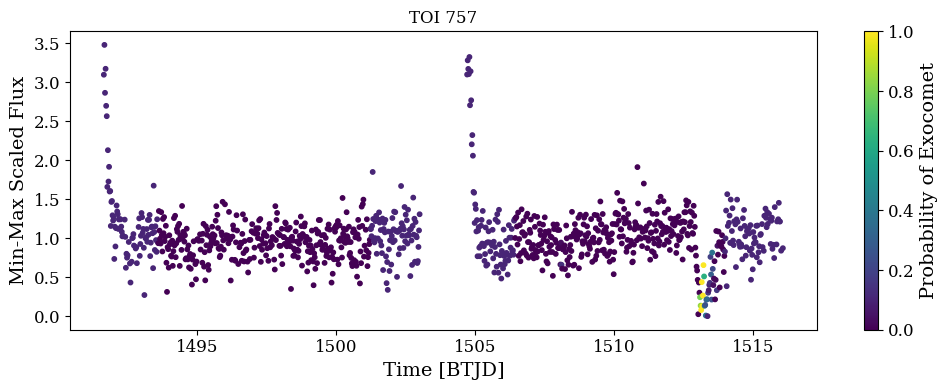

In [34]:
lc = lk.search_lightcurve('TIC 110969638',author='GSFC-ELEANOR-LITE').download()
lc = lc[lc.quality.value == 0]

f = np.array((lc.flux.value/np.nanmedian(lc.flux.value)) - 1)
f = np.array(f / np.nanstd((lc.flux.value/np.nanmedian(lc.flux.value))-1))
f = f + 1
f = f[~np.isnan(f)]
f = (f - np.min(f)) / (np.max(f) - np.min(f))
cnn.predict(modelname=modelname,
            times=lc.time.value,
            fluxes=f,
            errs=lc.flux_err.value)

plt.figure(figsize=(10,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=cnn.predictions[0], vmin=0, vmax=1,s=10)
plt.colorbar(label='Probability of Exocomet')
#plt.axvline(cnn.predict_time[0][np.argmax(cnn.predictions)],color='red',linestyle='--',zorder=1)
plt.xlabel('Time [BTJD]')
plt.title('TOI 757')
plt.tight_layout()
plt.ylabel('Min-Max Scaled Flux')
plt.gcf().patch.set_alpha(0.5)
plt.savefig('betapic-s5.png',dpi=300,bbox_inches='tight')

### Beta Pic

In [1]:
lc = lk.search_lightcurve('Beta Pic',mission='TESS',sector=[6],author='TESS-SPOC').download_all().stitch()
lc = lc[lc.quality.value == 0]

f = np.array((lc.flux.value/np.nanmedian(lc.flux.value)) - 1)
f = np.array(f / np.nanstd((lc.flux.value/np.nanmedian(lc.flux.value))-1))
f = f + 1
f = f[~np.isnan(f)]
f = (f - np.min(f)) / (np.max(f) - np.min(f))

cnn.predict(modelname=modelname,
            times=lc.time.value,
            fluxes=f,
            errs=lc.flux_err.value)

plt.figure(figsize=(10,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=cnn.predictions[0], vmin=0, vmax=1,s=10)
plt.colorbar(label='Probability of Exocomet')
#plt.axvline(cnn.predict_time[0][np.argmax(cnn.predictions)],color='red',linestyle='--',zorder=1)
plt.xlabel('Time [BTJD]')
plt.title('Beta Pic - Sector 5')
plt.tight_layout()
plt.ylabel('Min-Max Scaled Flux')
plt.gcf().patch.set_alpha(0.5)
plt.savefig('betapic-s5.png',dpi=300,bbox_inches='tight')

NameError: name 'lk' is not defined

---
### KIC 11084727

100%|█| 1/1 [00:00<00:


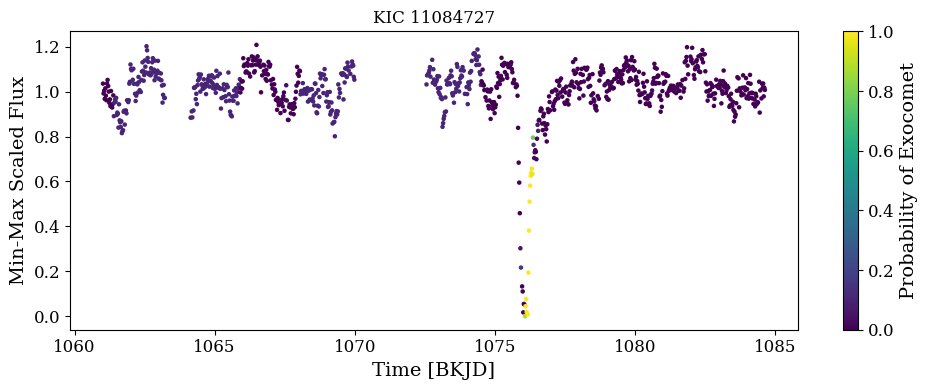

In [24]:
lc = lk.search_lightcurve('KIC 11084727')[12].download()
lc = lc[lc.quality.value == 0]

f = np.array((lc.flux.value/np.nanmedian(lc.flux.value)) - 1)
f = np.array(f / np.nanstd((lc.flux.value/np.nanmedian(lc.flux.value))-1))
f = f + 1
f = f[~np.isnan(f)]
f = (f - np.min(f)) / (np.max(f) - np.min(f))

cnn.predict(modelname=modelname,
            times=lc.time.value[0:-1],
            fluxes=f,
            errs=lc.flux_err.value[0:-1])

plt.figure(figsize=(10,4))
plt.scatter(cnn.predict_time[0][2300:3200], cnn.predict_flux[0][2300:3200],
            c=cnn.predictions[0][2300:3200], vmin=0, vmax=1,s=5)
plt.colorbar(label='Probability of Exocomet')
plt.title('KIC 11084727')
#plt.axvline(cnn.predict_time[0][np.argmax(cnn.predictions)],color='red',linestyle='--',zorder=1)
plt.xlabel('Time [BKJD]')
plt.ylabel('Min-Max Scaled Flux')
plt.gcf().patch.set_alpha(0.5)
plt.tight_layout()
plt.savefig('kic11084727.png',bbox_inches='tight')

---

## KIC 3542116

100%|█| 1/1 [00:00<00:


Text(0, 0.5, 'Normalised Flux')

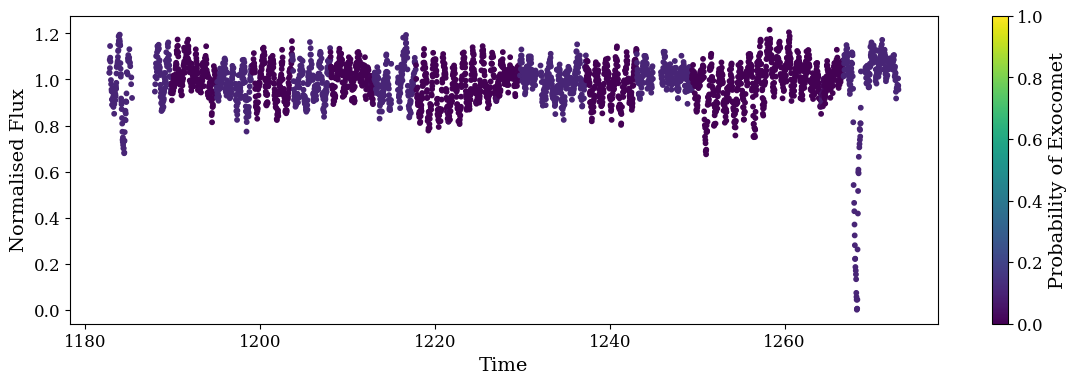

In [25]:
lc = lk.search_lightcurve('KIC 3542116')[13].download()
lc = lc[lc.quality.value == 0]

f = np.array((lc.flux.value/np.nanmedian(lc.flux.value)) - 1)
f = np.array(f / np.nanstd((lc.flux.value/np.nanmedian(lc.flux.value))-1))
f = f + 1
f = f[~np.isnan(f)]
f = (f - np.min(f)) / (np.max(f) - np.min(f))

cnn.predict(modelname=modelname,
            times=lc.time.value[0:-1],
            fluxes=f,
            errs=lc.flux_err.value[0:-1])

plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=cnn.predictions[0], vmin=0, vmax=1,s=10)
plt.colorbar(label='Probability of Exocomet')
#plt.axvline(cnn.predict_time[0][np.argmax(cnn.predictions)],color='red',linestyle='--',zorder=1)
plt.xlabel('Time')
plt.ylabel('Normalised Flux')


100%|█| 1/1 [00:00<00:


Text(0, 0.5, 'Min-Max Scaled Flux')

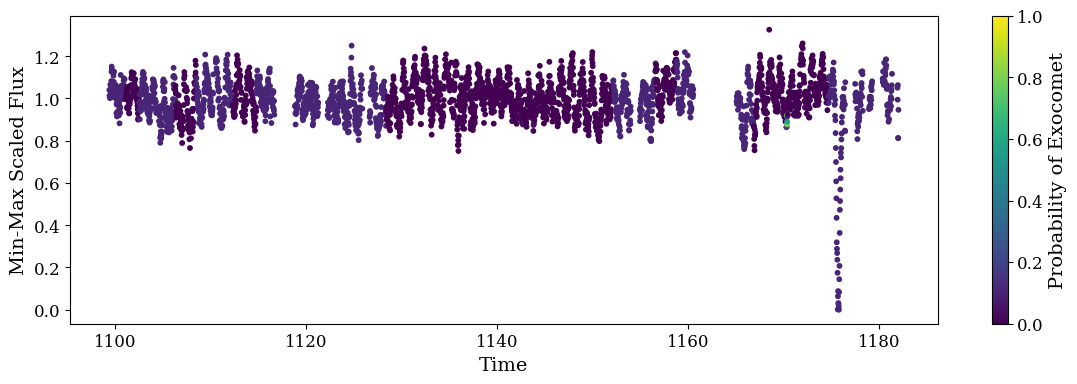

In [26]:
lc = lk.search_lightcurve('KIC 3542116')[12].download()
lc = lc[lc.quality.value == 0]

f = np.array((lc.flux.value/np.nanmedian(lc.flux.value)) - 1)
f = np.array(f / np.nanstd((lc.flux.value/np.nanmedian(lc.flux.value))-1))
f = f + 1
f = f[~np.isnan(f)]
f = (f - np.min(f)) / (np.max(f) - np.min(f))

cnn.predict(modelname=modelname,
            times=lc.time.value[0:-1],
            fluxes=f,
            errs=lc.flux_err.value[0:-1])

plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=cnn.predictions[0], vmin=0, vmax=1,s=10)
plt.colorbar(label='Probability of Exocomet')
#plt.axvline(cnn.predict_time[0][np.argmax(cnn.predictions)],color='red',linestyle='--',zorder=1)
plt.xlabel('Time')
plt.ylabel('Min-Max Scaled Flux')


100%|█| 1/1 [00:00<00:


Text(0, 0.5, 'Normalised Flux')

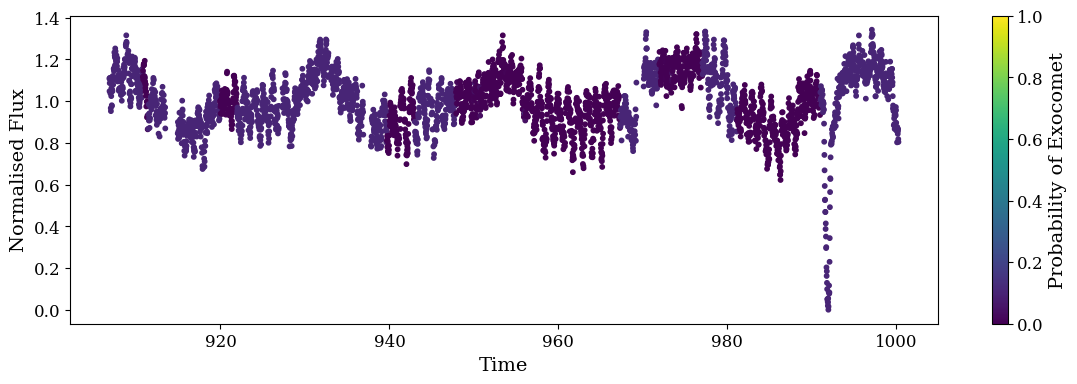

In [27]:
lc = lk.search_lightcurve('KIC 3542116')[8].download()
lc = lc[lc.quality.value == 0]

f = np.array((lc.flux.value/np.nanmedian(lc.flux.value)) - 1)
f = np.array(f / np.nanstd((lc.flux.value/np.nanmedian(lc.flux.value))-1))
f = f + 1
f = f[~np.isnan(f)]
f = (f - np.min(f)) / (np.max(f) - np.min(f))

cnn.predict(modelname=modelname,
            times=lc.time.value[0:-1],
            fluxes=f,
            errs=lc.flux_err.value[0:-1])

plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=cnn.predictions[0], vmin=0, vmax=1,s=10)
plt.colorbar(label='Probability of Exocomet')
#plt.axvline(cnn.predict_time[0][np.argmax(cnn.predictions)],color='red',linestyle='--',zorder=1)
plt.xlabel('Time')
plt.ylabel('Normalised Flux')


---

### KIC 8027456

In [28]:
lc = lk.search_lightcurve('KIC 8027456')[10].download()
lc = lc[lc.quality.value == 0]

100%|█| 1/1 [00:00<00:


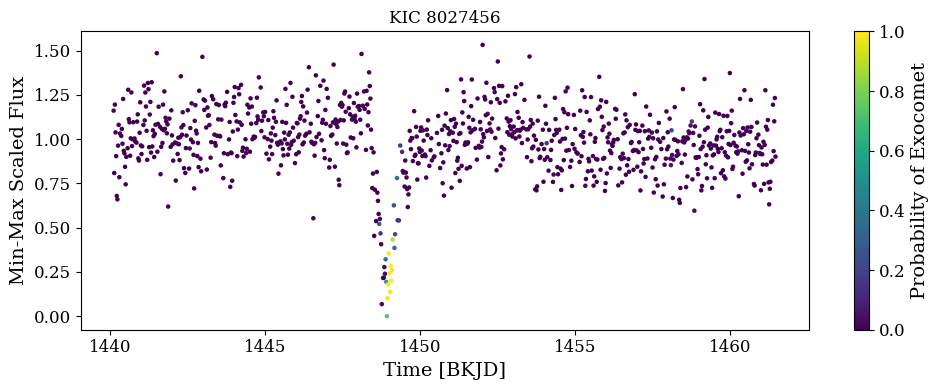

In [29]:
f = np.array((lc.flux.value/np.nanmedian(lc.flux.value)) - 1)
f = np.array(f / np.nanstd((lc.flux.value/np.nanmedian(lc.flux.value))-1))
f = f + 1
f = f[~np.isnan(f)]
f = (f - np.min(f)) / (np.max(f) - np.min(f))

cnn.predict(modelname=modelname,
            times=lc.time.value[0:-1],
            fluxes=f,
            errs=lc.flux_err.value[0:-1])

plt.figure(figsize=(10,4))
plt.scatter(cnn.predict_time[0][2500:3400], cnn.predict_flux[0][2500:3400],
            c=cnn.predictions[0][2500:3400], vmin=0, vmax=1,s=5)
plt.colorbar(label='Probability of Exocomet')
plt.title('KIC 8027456')
#plt.axvline(cnn.predict_time[0][np.argmax(cnn.predictions)],color='red',linestyle='--',zorder=1)
plt.xlabel('Time [BKJD]')
plt.ylabel('Min-Max Scaled Flux')
plt.gcf().patch.set_alpha(0.5)
plt.tight_layout()
plt.savefig('kic80274562.png',dpi=300,bbox_inches='tight')

### KIC 8462852


100%|█| 1/1 [00:00<00:


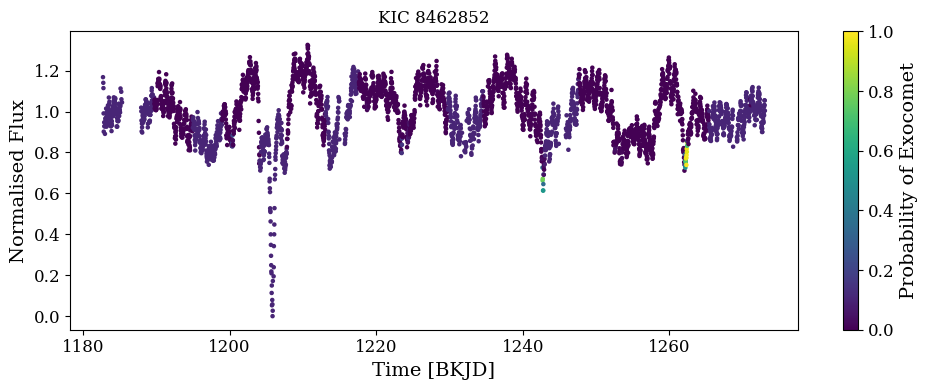

In [30]:
lc = lk.search_lightcurve('KIC 8462852')[13].download()
lc = lc[lc.quality.value == 0]

f = np.array((lc.flux.value/np.nanmedian(lc.flux.value)) - 1)
f = np.array(f / np.nanstd((lc.flux.value/np.nanmedian(lc.flux.value))-1))
f = f + 1
f = f[~np.isnan(f)]
f = (f - np.min(f)) / (np.max(f) - np.min(f))

cnn.predict(modelname=modelname,
            times=lc.time.value[0:-1],
            fluxes=f,
            errs=lc.flux_err.value[0:-1])

plt.figure(figsize=(10,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=cnn.predictions[0], vmin=0, vmax=1,s=5)
plt.colorbar(label='Probability of Exocomet')
plt.title('KIC 8462852')
#plt.axvline(cnn.predict_time[0][np.argmax(cnn.predictions)],color='red',linestyle='--',zorder=1)
plt.xlabel('Time [BKJD]')
plt.ylabel('Normalised Flux')
plt.gcf().patch.set_alpha(0.5)
plt.tight_layout()
plt.savefig('kic8462852.png',dpi=300,bbox_inches='tight')

## Predictions for 272-candidates

In [31]:
max_pred = []
folderpredict = '../predict-plots/'
os.makedirs(folderpredict,exist_ok=True)
for i in files3:
    file = np.load(i,allow_pickle=True)
    tic = i.split('/')[-1].split('.npy')[0]
    f = file[1]
    f = np.array(f / np.nanstd((f/np.nanmedian(f))-1))
    f = f + 1
    f = f[~np.isnan(f)]
    f = (f - np.min(f)) / (np.max(f) - np.min(f))
    
    cnn.predict(modelname=modelname,
                times=file[0],
                fluxes=f,
                errs=file[2])
    max_pred.append(np.max(cnn.predictions[0]))
    max_prediction = np.max(cnn.predictions[0])


    plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
              c=cnn.predictions[0], s=2, vmin=0, vmax=1)
    plt.title(f'TIC {tic}, max pred: {max_prediction:.2f}')
    plt.ylim([0,2])
    plt.savefig(f'{os.path.join(folderpredict,f"{tic}")}.png',dpi=200)
    plt.clf()

#plt.show()



NameError: name 'files3' is not defined

### Predictions for negative

In [129]:
max_pred_neg = []
folderpredictneg = '../predict-plots-neg/'
os.makedirs(folderpredictneg,exist_ok=True)
for i in files3:
    file = np.load(i,allow_pickle=True)
    tic = i.split('/')[-1].split('.npy')[0]
    f = file[1]
    f = np.array(f / np.nanstd((f/np.nanmedian(f))-1))
    f = f + 1
    f = f[~np.isnan(f)]
    f = (f - np.min(f)) / (np.max(f) - np.min(f))
    
    cnn.predict(modelname=modelname,
                times=file[0],
                fluxes=f[::-1],
                errs=file[2])
    max_pred_neg.append(np.max(cnn.predictions[0]))
    max_prediction = np.max(cnn.predictions[0])


    plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
              c=cnn.predictions[0], s=2, vmin=0, vmax=1)
    plt.title(f'TIC {tic}, max pred: {max_prediction:.2f}')
    plt.ylim([0,2])
    plt.savefig(f'{os.path.join(folderpredictneg,f"{tic}")}-negative.png',dpi=200)
    plt.clf()

#plt.show()


100%|████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


<Figure size 640x480 with 0 Axes>

In [130]:
success = [value for value in max_pred if value > 0.8]
frac = len(success)/len(max_pred)
frac

0.3940520446096654

In [131]:
success_neg = [value for value in max_pred_neg if value > 0.8]
frac_neg = len(success_neg)/len(max_pred_neg)
frac_neg

0.26394052044609667

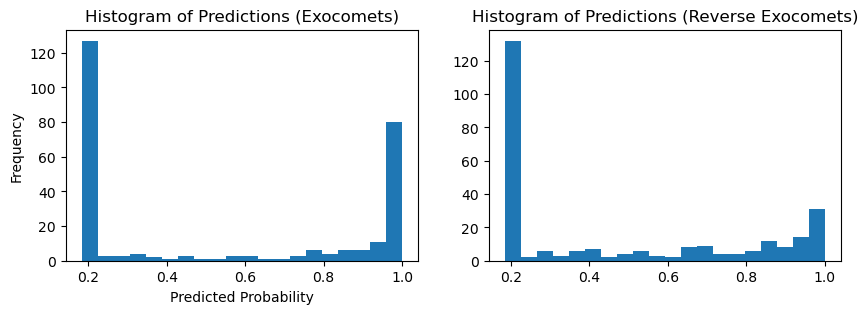

In [132]:
fig2, ax2 = plt.subplots(1,2,figsize=(10, 3))
ax2[0].hist(max_pred, bins=20)
ax2[0].set_title('Histogram of Predictions (Exocomets)')
ax2[0].set_xlabel('Predicted Probability')
ax2[0].set_ylabel('Frequency')

ax2[1].hist(max_pred_neg,bins=20)
ax2[1].set_title('Histogram of Predictions (Reverse Exocomets)')


plt.show()